<a href="https://colab.research.google.com/github/engineerjkk/LinkPrediction/blob/main/Link_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code Implementation  
We now implement the framework in python. First, we import the necessary packages.  

In [1]:
import networkx as nx
import math
import itertools
import numpy as np

In [3]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
u, v = g.edges()
u_list=u.tolist()
v_list=v.tolist()
u_list = list(map(int, u_list))
v_list = list(map(int, v_list))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


To show how the framework is utilised in practice, we’ll use a dummy graph provided by Tan et. al. (2014).   
We use networkx to define the graph object.

In [4]:
def comb(n, k):
    if (n<0 or k<0):
        return None
    else:
        return math.factorial(n)/(math.factorial(k)*math.factorial(n-k))

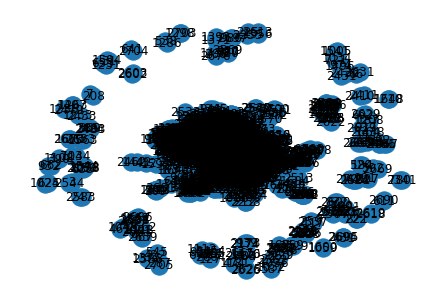

In [5]:
G = nx.Graph()
edgeList = [(i,j) for i,j in zip(u_list,v_list)]
G.add_edges_from(edgeList)
nx.draw(G, with_labels=True)

Next, we define the likelihood score as a function that takes in node x and y.  
It consists of several loops aggregating information from common neighbours of node x and y.  
The framework takes in two probabilities model: prior and likelihood that we’ll describe next.

In [6]:
# score based on mutual information
def s(x , y, prior, likelihood):
 # common neighbors
 CN = nx.common_neighbors(G, x, y)
 # prior (x, y)
 priorXY = - np.log2(prior(x, y, G))

 # sum over neighbors
 cnMI = 0
 for z in CN:
   # degree of z
   kz = G.degree(z)
   coeffZ = 1 / (kz * (kz-1))
   # sum over edges = neighbors of z
   zMI = 0
   for m, n in itertools.combinations(G.neighbors(z), 2):
     priorInfo = -np.log2(prior(m, n, G))
     likelihoodInfo = -np.log2(likelihood(z, G))
     # combine mutual information
     zMI += 2 * (priorInfo -likelihoodInfo)
   # add average mutual information per neighbor
   cnMI += coeffZ * zMI
 return cnMI -priorXY

We now define prior as a function of the combinatorics probability.

In [10]:
def prior(m, n, G):
 kn = G.degree(n)
 km = G.degree(m)
 M = G.number_of_edges()
 print("kn : ",kn)
 print("km : ",km)
 print("M : ", M)
 
 return 1-(comb(M-kn, km))/(comb(M, km))

Meanwhile, likelihood is defined as the clustering coefficient of common neighbour z of node x and y.

In [11]:
def likelihood(z, G):
 kz = G.degree(z)
 print("kz : ",kz)
 N_triangles = nx.triangles(G, z)
 print("N_triangles : ",N_triangles)
 N_triads = comb(kz, 2)
 print("N_triads : ",N_triads)
 
 return N_triangles / N_triads

We have now defined the whole framework. Following the example provided by Tan et. al. (2014),  
we can calculate the score for node 2 and 3 by calling the s function.  
And voilà! we get -1.667, precisely as shown in the paper.

In [12]:
# -1.667
s(35, 1033, prior, likelihood)

kn :  3
km :  3
M :  5278


-9.196397489036583

In [14]:

s(35, 1034, prior, likelihood)

-10.780813134605147

In [15]:

s(35, 1035, prior, likelihood)

-7.975098985238935

Conclusion  
We have seen how to integrate the link prediction problem into the information-theoretic framework.  
Using the latter, we could plug in a few different probability models depending on our choice.  
In this article, we have looked at one particular model based on clustering coefficient and combinatorics probability.  
For more types of models, please refer to Tan et. al.  
(2014) and Kumar and Sharma (2020).